In [25]:
import pandas as pd
import sys
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib as mpl
import os

# custom imports
REPO_PATH = "C:/Users/soysa/Documents/Git/visual_encoding"
import sys
sys.path.append(REPO_PATH)
from allen_vc.sensitivity_analysis import sensitivity_analysis
from allen_vc.plts import linregress_movie_v_shuffled_plot, plot_sa_heat_map
from allen_vc.utils import combine_spike_lfp_dfs, channel_medians

mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams["font.family"] = "sans-serif"

print("Packages Imported")

Packages Imported


In [2]:
# settings
PROJECT_PATH = 'G:/Shared drives/visual_encoding'
SPIKES_IN = 'data/spike_data/synchrony_data'
LFP_IN = 'data/lfp_data/lfp_params'

In [3]:
# load spike metric data
movie_synchrony_df = pd.read_csv(f'{PROJECT_PATH}/{SPIKES_IN}/VISp-LGd_natural_movie.csv')
# load lfp psd data
movie_lfp_df = pd.read_csv(f'{PROJECT_PATH}/{LFP_IN}/natural_movie/all_params.csv').drop(columns="Unnamed: 0").drop(columns="Unnamed: 0.1")

In [4]:
shuffled_synchrony_df = pd.read_csv(f'{PROJECT_PATH}/{SPIKES_IN}/VISp-LGd_natural_movie_shuffled.csv')
shuffled_lfp_df = pd.read_csv(f'{PROJECT_PATH}/{LFP_IN}/natural_movie_shuffled/lfp_params.csv')

In [5]:
# create directory to save figures
dir_figures = f"{PROJECT_PATH}/figures/offset_vs_rate/behavior_independent"
if not os.path.exists(dir_figures):
    os.makedirs(dir_figures)

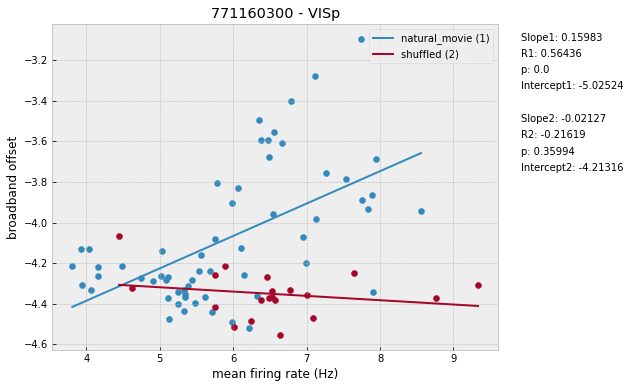

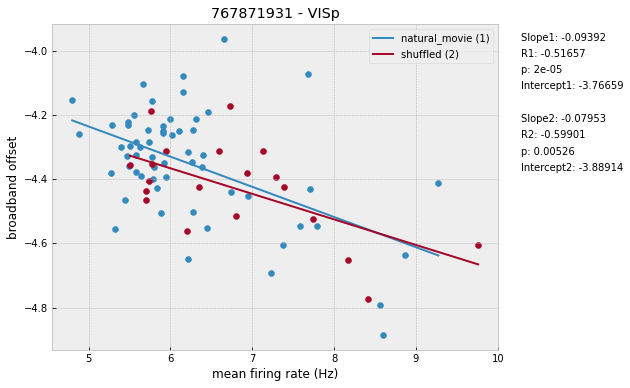

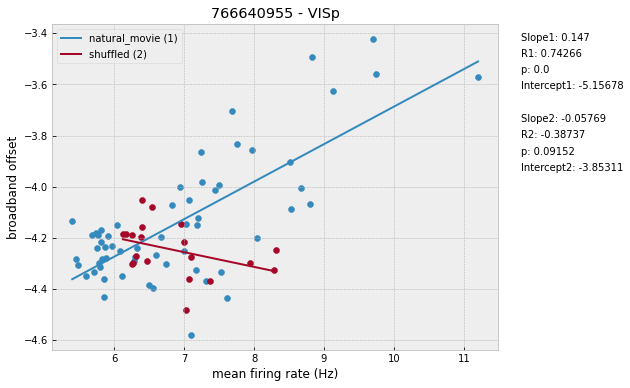

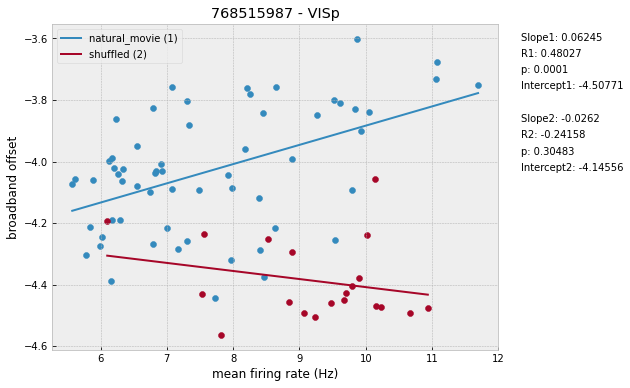

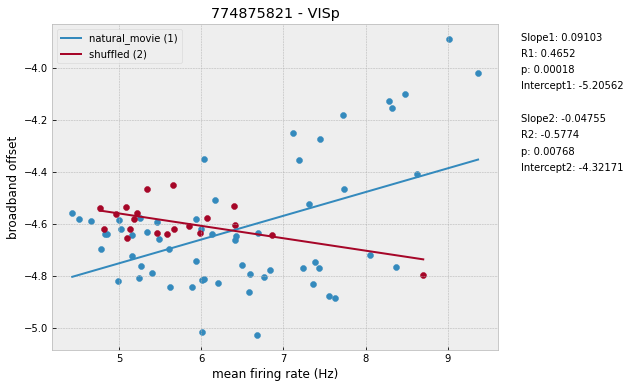

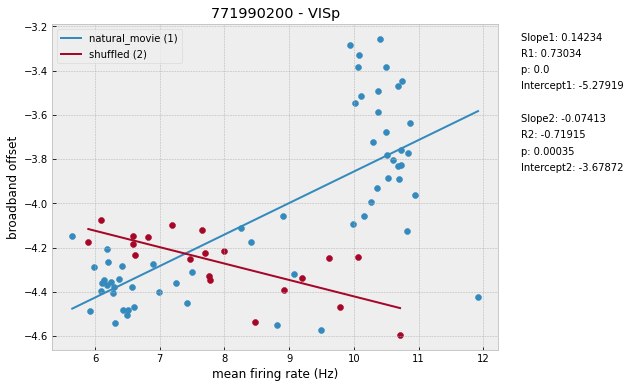

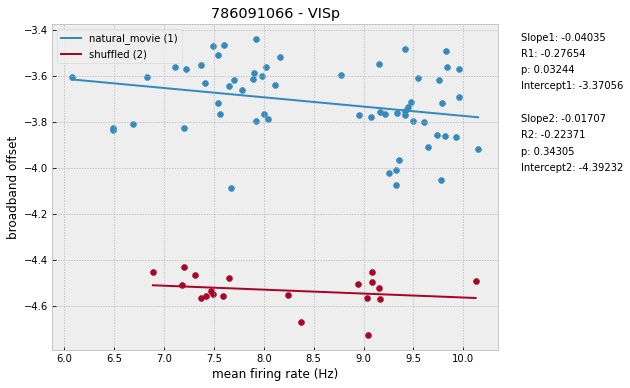

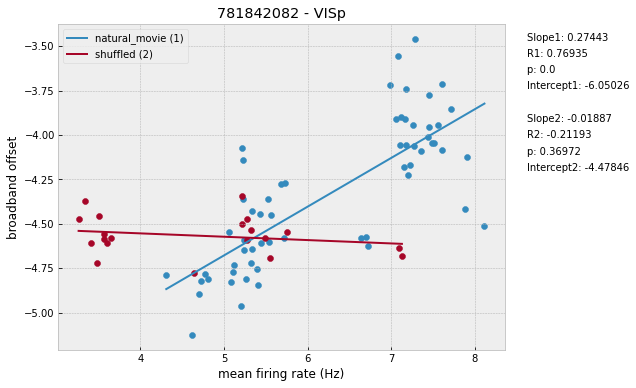

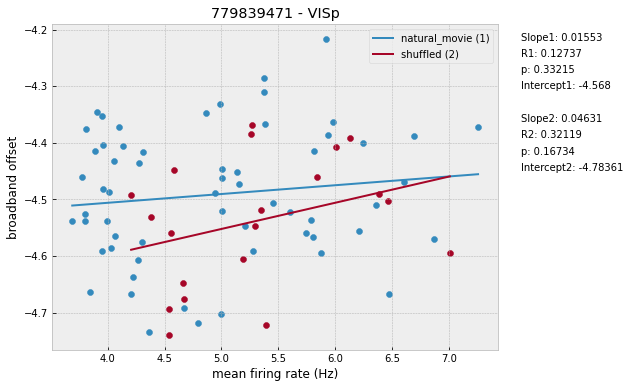

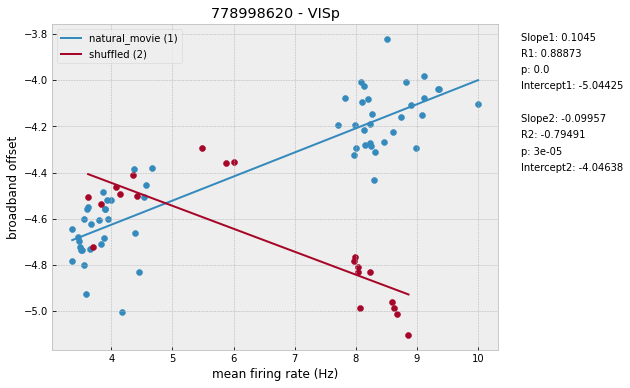

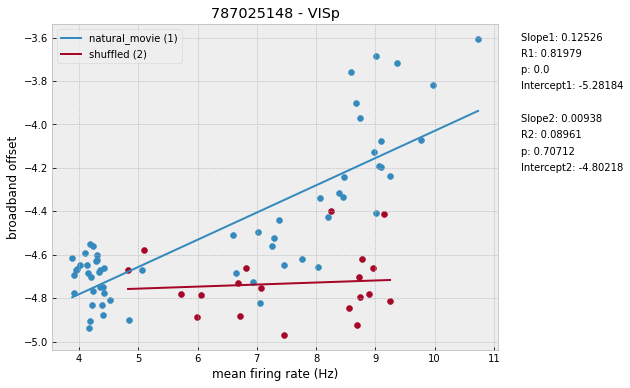

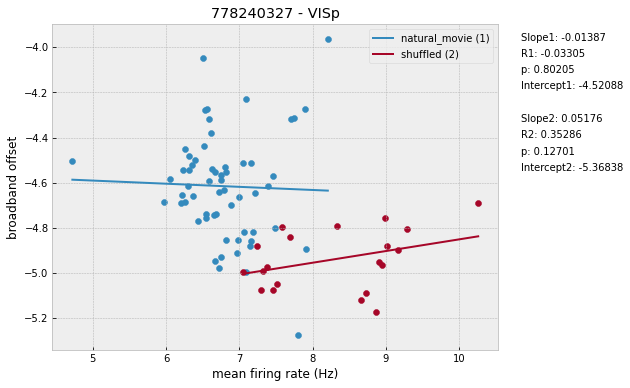

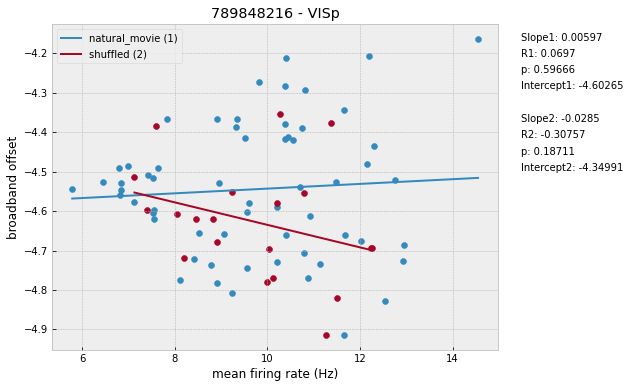

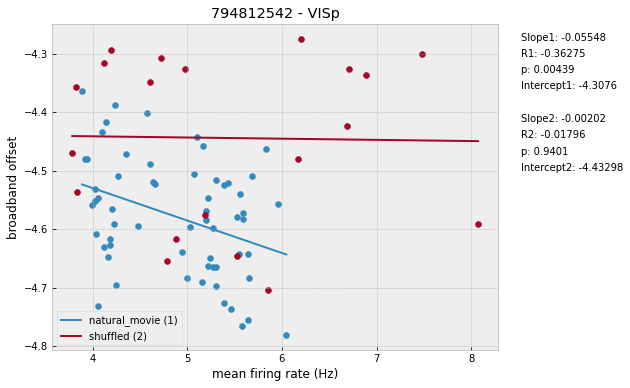

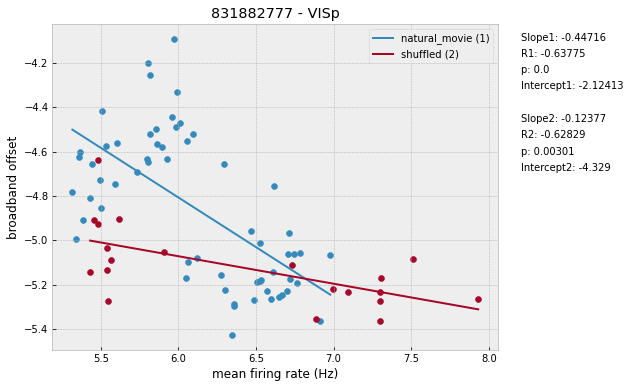

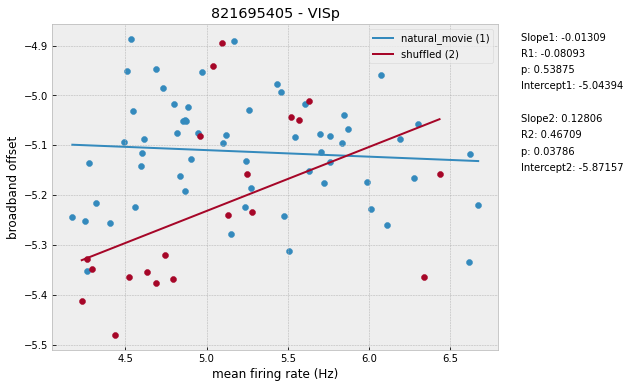

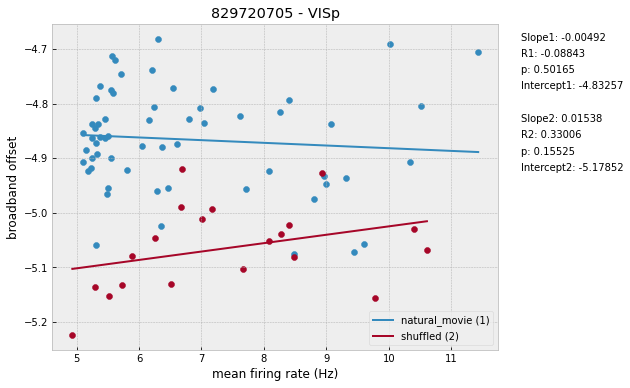

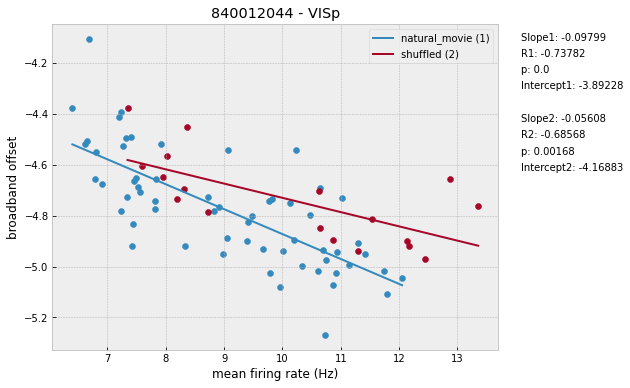

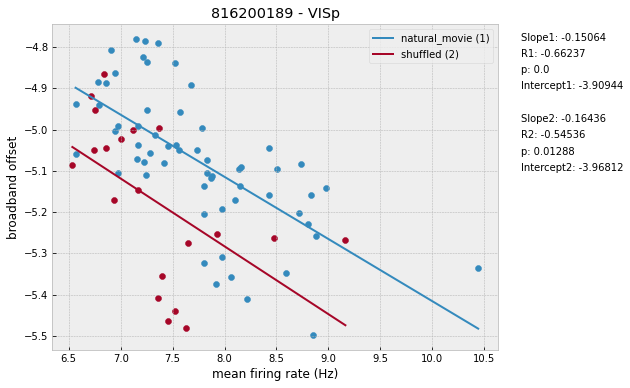

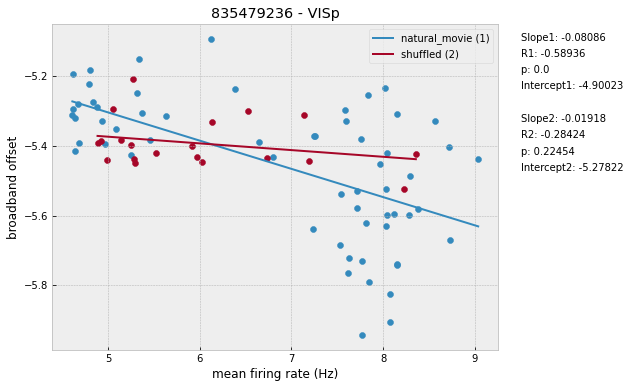

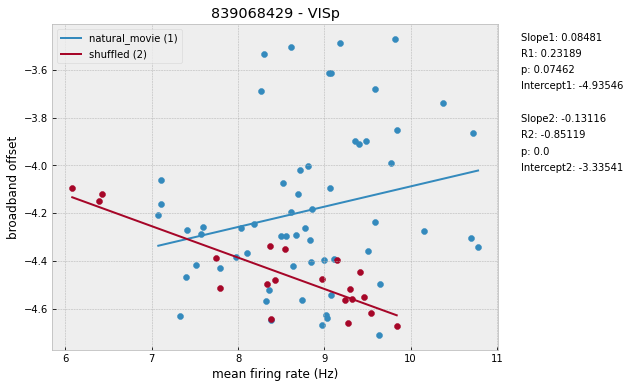

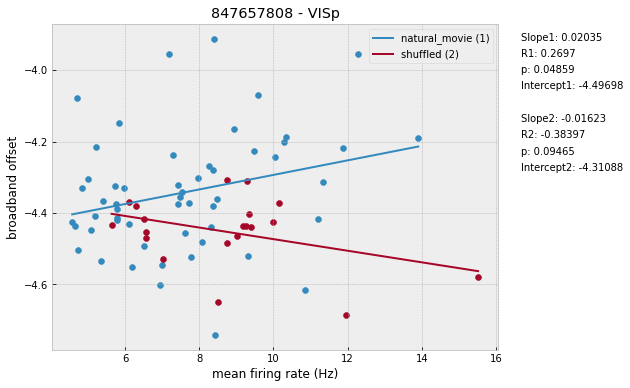

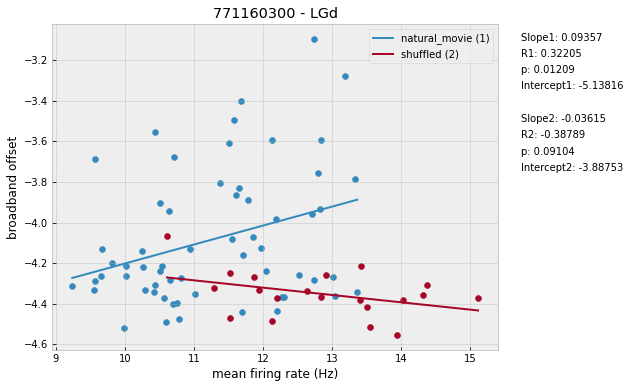

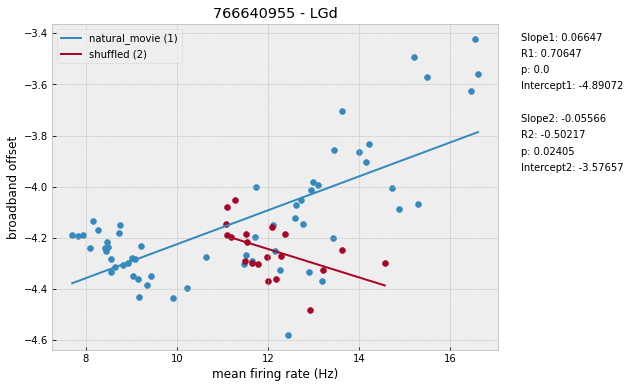

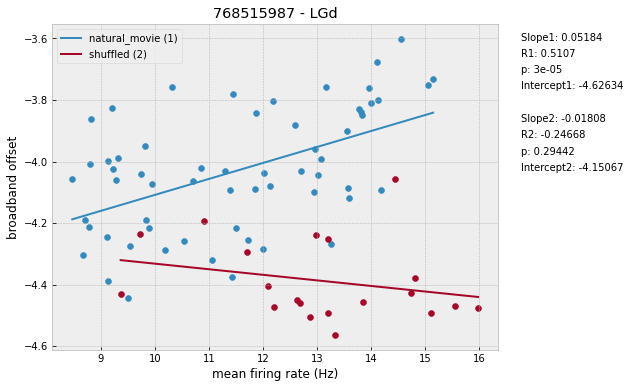

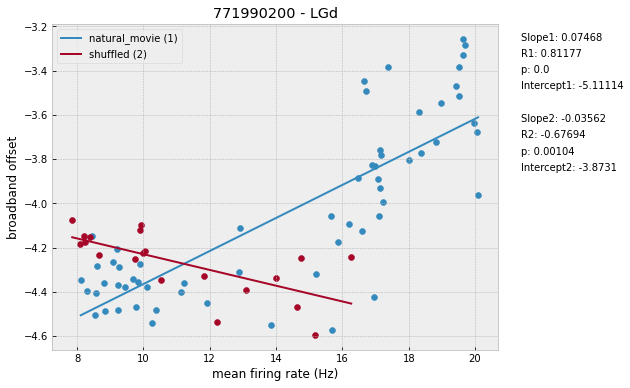

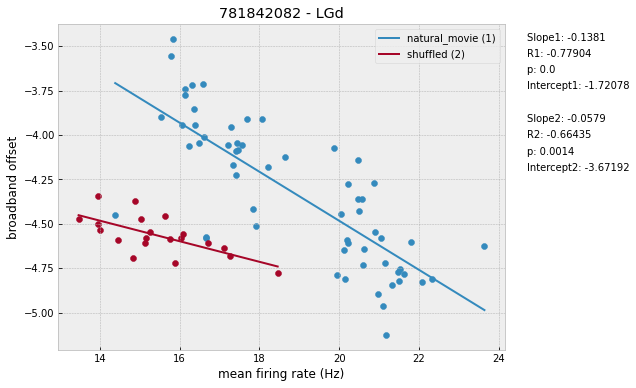

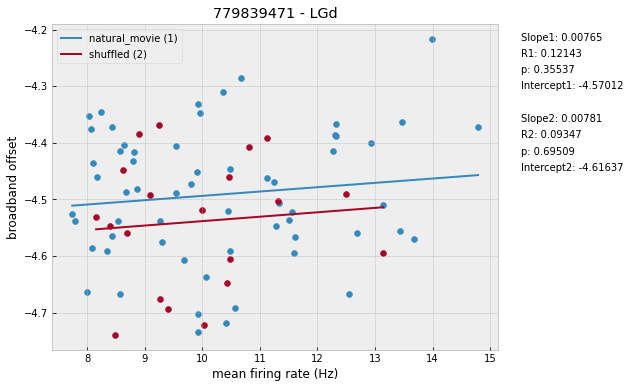

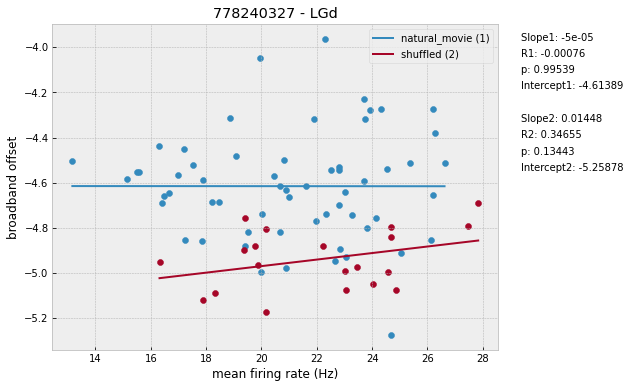

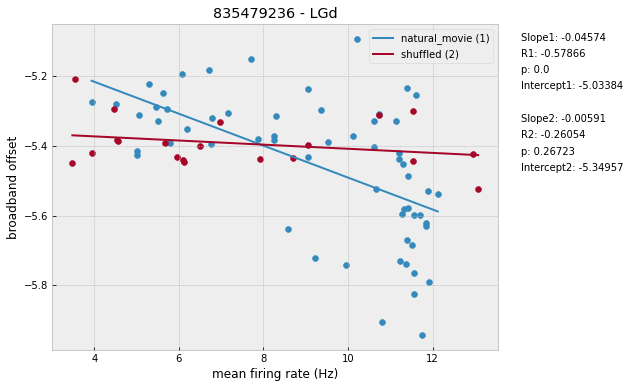

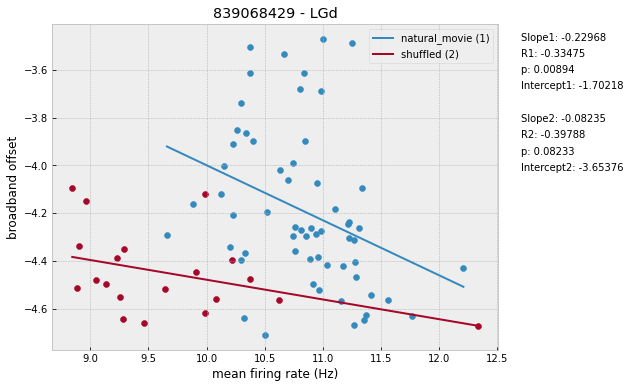

In [6]:
regions = ['VISp', 'LGd']

for region in regions:
    # iterate over each session and join dataframes
    for ses_id in movie_synchrony_df.get('session').unique():
        
        if ses_id == 793224716 or ses_id not in movie_synchrony_df\
        [movie_synchrony_df.get('brain_structure')==region].get('session').unique():
            continue
        
        # combine dfs with average across channels
        movie_lfp_sync = combine_spike_lfp_dfs(movie_synchrony_df, movie_lfp_df, ses_id, region)
            
        # create plots
        x_movie = movie_lfp_sync.get('mean_firing_rate')
        y_movie = movie_lfp_sync.get('offset')

        # repeat for shuffled data
        shuffled_lfp_sync = combine_spike_lfp_dfs(shuffled_synchrony_df, shuffled_lfp_df, ses_id, region)

        x_shuffled = shuffled_lfp_sync.get('mean_firing_rate')
        y_shuffled = shuffled_lfp_sync.get('offset')
            
        if len(movie_lfp_sync)==0 or len(shuffled_lfp_sync)==0:
            continue
                
        linregress_movie_v_shuffled_plot(x_movie, y_movie, x_shuffled, y_shuffled, f"{ses_id} - {region}", 
                                             "mean firing rate (Hz)", "broadband offset", 
                                             fname_out = f"{dir_figures}/{ses_id}_{region}",
                                             show=True);

### Merge unit and lfp results

In [8]:
# Merge unit and lfp dataframes (after necessary modifications)

# modify df_lfp - average over channels for each epoch within each session
df_lfp = movie_lfp_df.groupby(['session', 'epoch_idx']).mean().reset_index()

# modify df_unit - drop non-VISp rows
df_units = movie_synchrony_df.copy()
df_units = df_units[df_units.get("brain_structure")=="VISp"]    

# merge dataframes
df = df_lfp.merge(df_units, on=['session', 'epoch_idx'])
df

,session,epoch_idx,offset,knee,exponent,r_squared,cf_0,pw_0,bw_0,cf_1,...,chan_idx,mean_firing_rate,unit_firing_rates,coefficient_of_variation,spike_distance,spike_synchrony,correlation_coefficient,epoch_times,running,brain_structure
0,766640955,0.0,-4.860576,1188.476113,1.938520,0.920563,16.315592,0.527971,4.110032,67.971192,...,10.5,7.613462,"[9.933333333333334, 4.866666666666666, 2.3, 0....",1.397554,0.373022,0.166795,[[ 1. 0.06956156 0.03174138 ... 0.0...,"[array(2297.21288415) * s, array(2327.21288415...",False,VISp
1,766640955,1.0,-4.840959,243.044655,1.958613,0.928544,16.089610,0.408364,4.154759,77.684014,...,10.5,6.503846,"[12.866666666666667, 3.033333333333333, 1.9333...",1.805933,0.356343,0.156179,[[ 1. 0.28654797 -0.11920837 ... -0.2...,"[array(2327.23768415) * s, array(2357.23796415...",False,VISp
2,766640955,2.0,-4.734913,448.006152,2.018242,0.929696,20.044242,0.327437,3.952711,68.648654,...,10.5,5.717949,"[7.333333333333333, 2.433333333333333, 1.83333...",2.085702,0.355914,0.144663,[[ 1. 0.52801102 -0.43696716 ... -0.2...,"[array(2357.26309415) * s, array(2387.26328415...",False,VISp
3,766640955,3.0,-4.808460,120.219652,1.976962,0.929683,14.305838,0.325696,6.565642,111.696998,...,10.5,6.325000,"[5.066666666666666, 2.5, 1.4, 0.36666666666666...",2.286680,0.356209,0.150416,[[ 1. 0.30124503 -0.1708901 ... -0.2...,"[array(2387.28808415) * s, array(2417.28815415...",False,VISp
4,766640955,4.0,-4.841887,410.098697,1.968394,0.929065,30.627458,0.353131,4.655083,83.828503,...,10.5,5.859615,"[6.433333333333334, 2.933333333333333, 1.53333...",1.927220,0.360086,0.148029,[[ 1. 0.19865689 -0.15139859 ... -0.2...,"[array(2417.31288415) * s, array(2447.31325415...",False,VISp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,847657808,52.0,-4.016763,10500.716782,2.269703,0.944767,3.511688,0.692602,2.775793,25.718492,...,11.5,7.194667,"[10.166666666666666, 12.266666666666667, 3.4, ...",2.095516,0.338315,0.193469,[[ 1. 0.12724363 -0.11364702 ... 0.1...,"[array(8055.28008995) * s, array(8085.28014995...",False,VISp
1310,847657808,53.0,-4.206563,3353.808989,2.208916,0.948405,6.292553,0.637726,3.405758,31.568936,...,11.5,7.436000,"[9.933333333333334, 11.566666666666666, 3.8333...",2.155763,0.339750,0.196957,[[ 1. 0.34833705 0.15693015 ... 0.3...,"[array(8085.30494995) * s, array(8115.30503995...",False,VISp
1311,847657808,54.0,-4.283343,244.307778,2.221053,0.956467,14.354284,0.410176,3.454129,57.117312,...,11.5,8.472000,"[11.033333333333333, 17.2, 3.6666666666666665,...",1.887813,0.345569,0.216878,[[ 1. 0.01723852 -0.25895783 ... -0.0...,"[array(8115.32974995) * s, array(8145.32999995...",False,VISp
1312,847657808,55.0,-4.417281,73.436680,2.170956,0.957306,29.725250,0.388318,6.328461,82.357301,...,11.5,11.875333,"[17.766666666666666, 24.066666666666666, 4.266...",1.122379,0.350396,0.237174,[[ 1. 0.10384419 -0.31875367 ... 0.0...,"[array(8145.35454995) * s, array(8175.35491995...",True,VISp


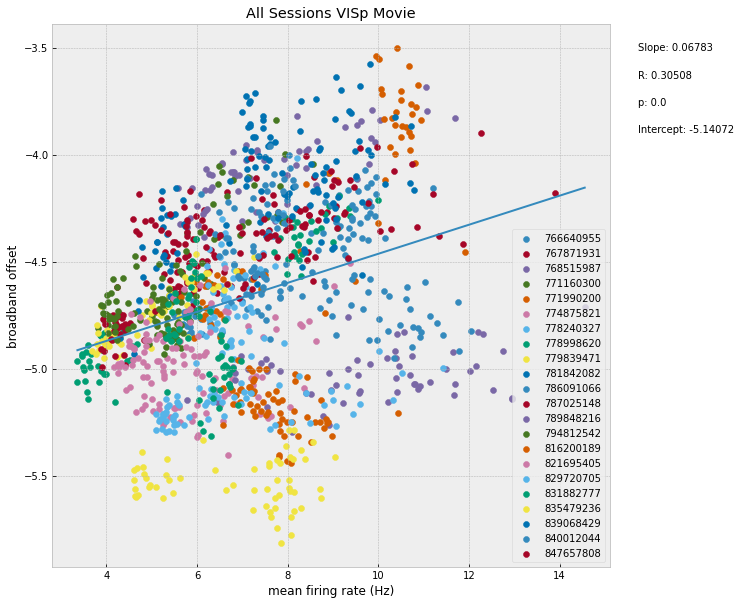

In [9]:
# Plot mean firing rate vs. broadband offset 

# plot each session
sessions = df.get('session').unique()
fig, ax = plt.subplots(figsize=(10, 10))
for ses in sessions:
    ses_df = df[df.get('session')==ses]
    ax.scatter(ses_df.get('mean_firing_rate'), ses_df.get('offset'), label=ses)
ax.legend()

# run regression across all epochs and plot results
x_data = df.get('mean_firing_rate')
y_data = df.get('offset')
results = sts.linregress(x_data, y_data)
l1 = np.linspace(min(x_data), max(x_data), 1000)
t1 = results.slope * l1 + results.intercept
ax.plot(l1, t1, label='natural_movie (1)')

# add labels
plt.text(1.05, 0.95, f"Slope: {round(results.slope, 5)}", transform = ax.transAxes)
plt.text(1.05, 0.9, f"R: {round(results.rvalue, 5)}", transform = ax.transAxes)
plt.text(1.05, 0.85, f"p: {round(results.pvalue, 5)}", transform = ax.transAxes)
plt.text(1.05, 0.8, f"Intercept: {round(results.intercept, 5)}", transform = ax.transAxes)

plt.xlabel("mean firing rate (Hz)")
plt.ylabel("broadband offset")

plt.title("All Sessions VISp Movie")

plt.savefig(f"{dir_figures}/movie_all_sessions")

#### combine movie and shuffled results

In [11]:
# combine

# copy dataframe and add column for condition
df_movie = df.copy()
df_movie['condition'] = 'movie'

# repeat unit-lfp merge for shuffled data
df_lfp = shuffled_lfp_df.groupby(['session', 'epoch_idx']).mean().reset_index()
df_units = shuffled_synchrony_df.copy()
df_units = df_units[df_units.get("brain_structure")=="VISp"]    
# NOTE - spike_pipeline/3_compute_spike_stats.py has been updated to do this column renaming
df_shuffled = df_lfp.merge(df_units, on=['session', 'epoch_idx'])
df_shuffled['condition'] = 'shuffled'

# combine movie and shuffled dataframes
df = pd.concat([df_movie, df_shuffled])
print(len(df))
df.head()

1752


,session,epoch_idx,offset,knee,exponent,r_squared,cf_0,pw_0,bw_0,cf_1,...,unit_firing_rates,coefficient_of_variation,spike_distance,spike_synchrony,correlation_coefficient,epoch_times,running,brain_structure,condition,Unnamed: 0
0,766640955,0.0,-4.860576,1188.476113,1.938520,0.920563,16.315592,0.527971,4.110032,67.971192,...,"[9.933333333333334, 4.866666666666666, 2.3, 0....",1.397554,0.373022,0.166795,[[ 1. 0.06956156 0.03174138 ... 0.0...,"[array(2297.21288415) * s, array(2327.21288415...",False,VISp,movie,NaN
1,766640955,1.0,-4.840959,243.044655,1.958613,0.928544,16.089610,0.408364,4.154759,77.684014,...,"[12.866666666666667, 3.033333333333333, 1.9333...",1.805933,0.356343,0.156179,[[ 1. 0.28654797 -0.11920837 ... -0.2...,"[array(2327.23768415) * s, array(2357.23796415...",False,VISp,movie,NaN
2,766640955,2.0,-4.734913,448.006152,2.018242,0.929696,20.044242,0.327437,3.952711,68.648654,...,"[7.333333333333333, 2.433333333333333, 1.83333...",2.085702,0.355914,0.144663,[[ 1. 0.52801102 -0.43696716 ... -0.2...,"[array(2357.26309415) * s, array(2387.26328415...",False,VISp,movie,NaN
3,766640955,3.0,-4.808460,120.219652,1.976962,0.929683,14.305838,0.325696,6.565642,111.696998,...,"[5.066666666666666, 2.5, 1.4, 0.36666666666666...",2.286680,0.356209,0.150416,[[ 1. 0.30124503 -0.1708901 ... -0.2...,"[array(2387.28808415) * s, array(2417.28815415...",False,VISp,movie,NaN
4,766640955,4.0,-4.841887,410.098697,1.968394,0.929065,30.627458,0.353131,4.655083,83.828503,...,"[6.433333333333334, 2.933333333333333, 1.53333...",1.927220,0.360086,0.148029,[[ 1. 0.19865689 -0.15139859 ... -0.2...,"[array(2417.31288415) * s, array(2447.31325415...",False,VISp,movie,NaN



Regression results: movie
LinregressResult(slope=0.06782776872413716, intercept=-5.14071580236219, rvalue=0.3050832933063205, pvalue=1.0516563350597246e-29, stderr=0.005845311753985732, intercept_stderr=0.04227483333634205)

Regression results: shuffled
LinregressResult(slope=0.028307730975766665, intercept=-5.095563227498583, rvalue=0.16429420434512712, pvalue=0.0005562766865121791, stderr=0.008139498478069338, intercept_stderr=0.06048751024060841)


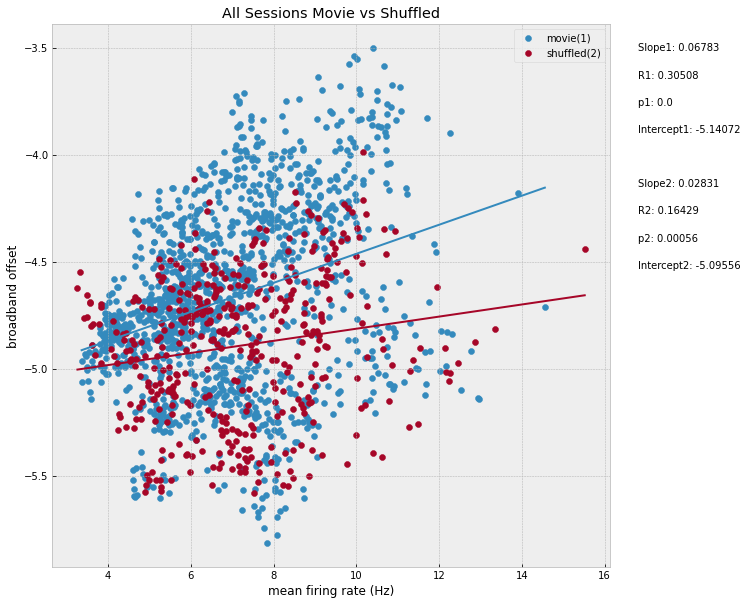

In [12]:
# plot mean firing rate vs. broadband offset for each condition

# create figure and label axes
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel('mean firing rate (Hz)')
ax.set_ylabel('broadband offset')
plt.title("All Sessions Movie vs Shuffled")

# plot each condition
for i, condition in enumerate(df.get('condition').unique()):
    # plot scatter for each condition
    df_cond = df[df.get('condition')==condition]
    ax.scatter(df_cond.get('mean_firing_rate'), df_cond.get('offset'), label=condition + f"({i+1})")

    # run regression for both conditions and plot results
    x_data = df_cond.get('mean_firing_rate')
    y_data = df_cond.get('offset')
    results = sts.linregress(x_data, y_data)
    line_x = np.linspace(min(x_data), max(x_data), 1000)
    line_y = results.slope * line_x + results.intercept
    ax.plot(line_x, line_y)

    # print results
    print(f"\nRegression results: {condition}")
    print(results)
    
    # add labels
    plt.text(1.05, 0.95 - (i*0.25), f"Slope{i+1}: {round(results.slope, 5)}", transform = ax.transAxes)
    plt.text(1.05, 0.9 - (i*0.25), f"R{i+1}: {round(results.rvalue, 5)}", transform = ax.transAxes)
    plt.text(1.05, 0.85 - (i*0.25), f"p{i+1}: {round(results.pvalue, 5)}", transform = ax.transAxes)
    plt.text(1.05, 0.8 - (i*0.25), f"Intercept{i+1}: {round(results.intercept, 5)}", transform = ax.transAxes)

plt.savefig(f"{dir_figures}/movie_v_shuffled_all_sessions")

# add legend
ax.legend()
plt.show();

#### run anova

In [18]:
# run repeated measuresanova 

# average over epochs within each session
df_sessions = df.groupby(['session', 'condition']).mean().reset_index()

# drop row 26 (missing coresponding data)
# NOTE - why?
# df_sessions = df_sessions.drop(index=26)

# loop over variables of interest
results = {}
for var in ['mean_firing_rate', 'offset', 'knee', 'exponent', 'coefficient_of_variation',
             'spike_synchrony', 'spike_distance']:
    # run anova
    results_i = sm.stats.AnovaRM(df_sessions, var, 'session', within=['condition']).fit()

    # aggregate
    results[var] = results_i

    # show results
    print(f"\n\n===================  {var}  ===================\n")
    print(results_i)



===================  mean_firing_rate  ===================

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
condition  1.4166 1.0000 21.0000 0.2472



===================  offset  ===================

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
condition 47.5672 1.0000 21.0000 0.0000



===================  knee  ===================

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
condition 18.0739 1.0000 21.0000 0.0004



===================  exponent  ===================

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
condition 43.8033 1.0000 21.0000 0.0000



===================  coefficient_of_variation  ===================

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
condition  2.6892 1.0000 21.0000 

# Sensitivity Analysis

In [19]:
import pandas as pd
import numpy as np
import os
import scipy.stats as sts
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

PROJECT_PATH = "G:/Shared drives/visual_encoding"
PSD_PATH = f"{PROJECT_PATH}/data/lfp_data/lfp_psd"
SPIKES_IN = f'{PROJECT_PATH}/data/spike_data/synchrony_data'
MATRICES_OUT = f'{PROJECT_PATH}/data/lfp_data/lfp_r_matrices'

mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams["font.family"] = "sans-serif"

print("Packages Imported")

Packages Imported


# Natural Movie

In [20]:
# create directory to save figures
dir_figures = f"{PROJECT_PATH}/figures/sensitivity_analysis/natural_movie/behavior_independent"
if not os.path.exists(dir_figures):
    os.makedirs(dir_figures + "/non_masked")
    os.makedirs(dir_figures + "/masked")

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

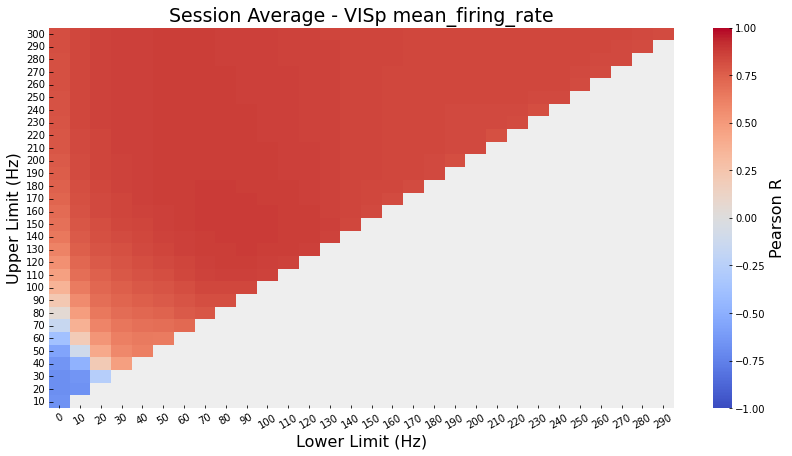

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

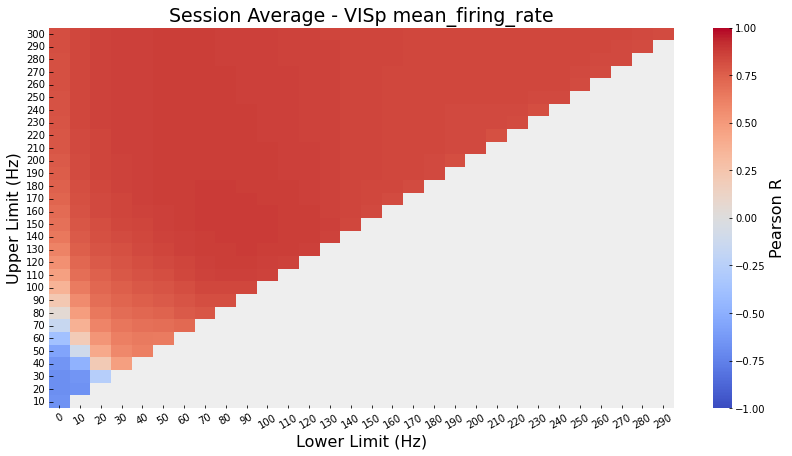

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

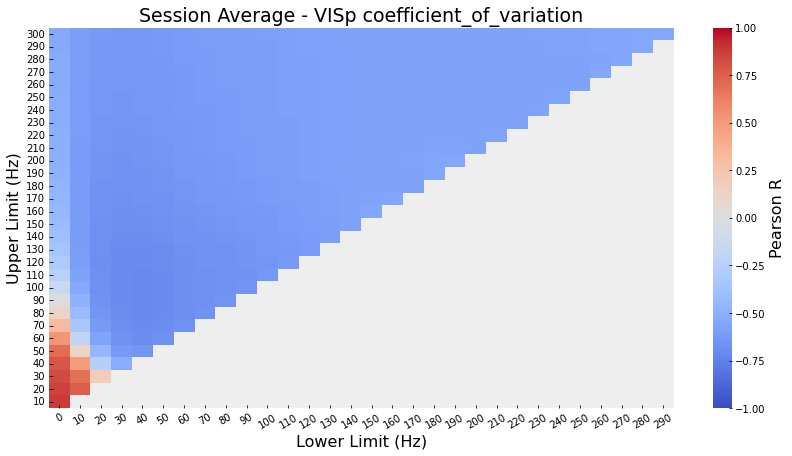

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

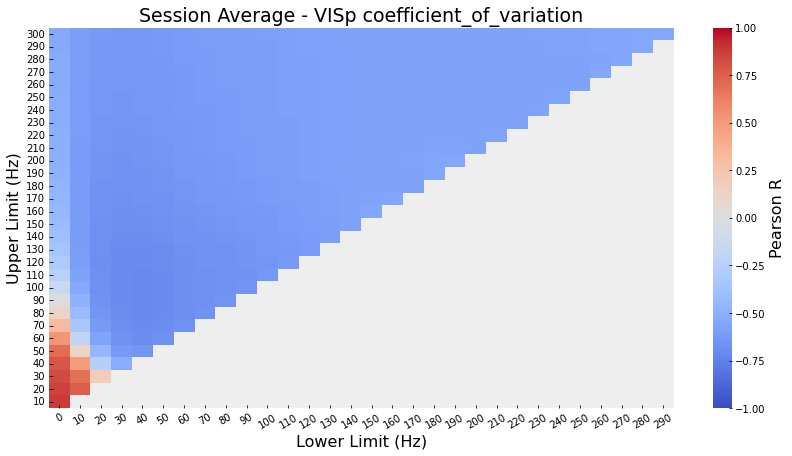

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

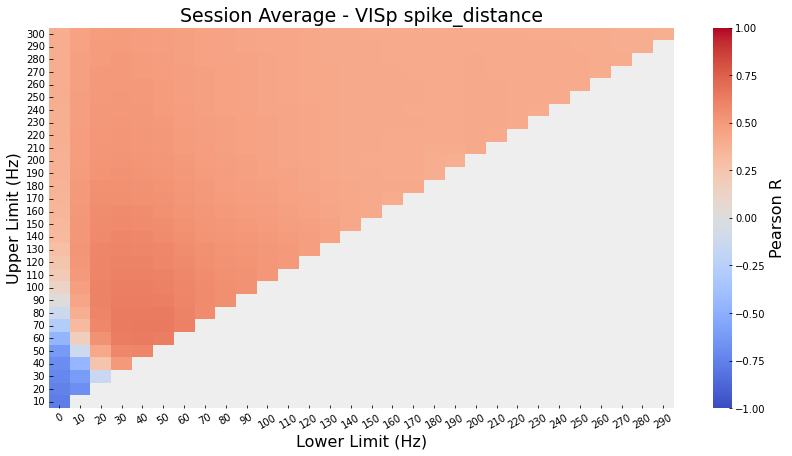

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

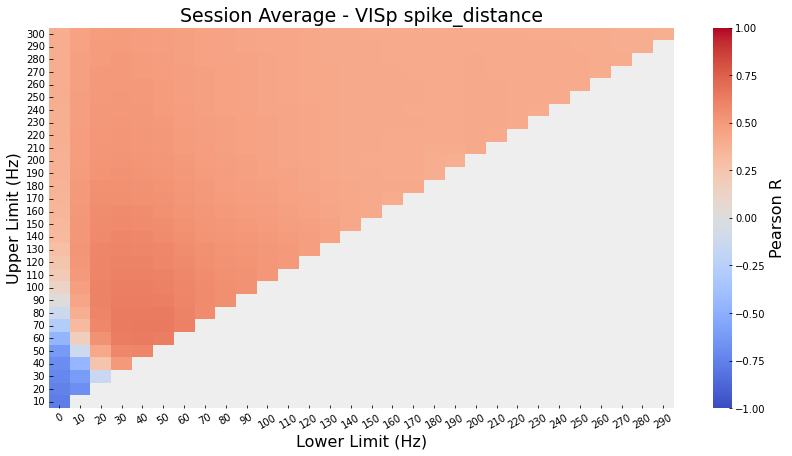

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

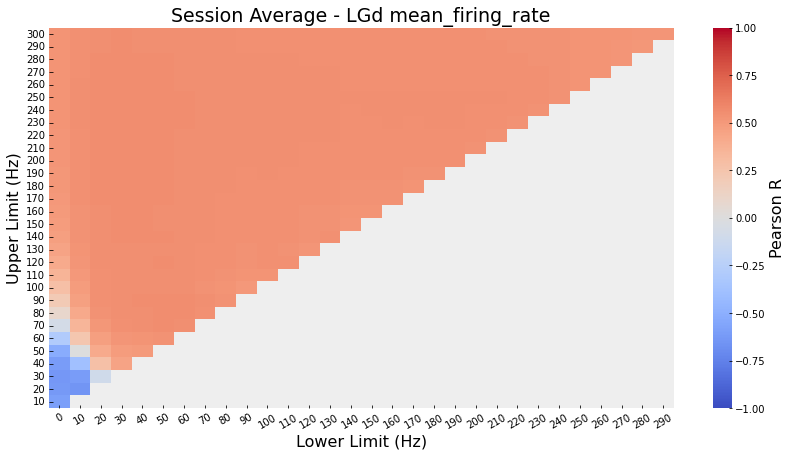

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

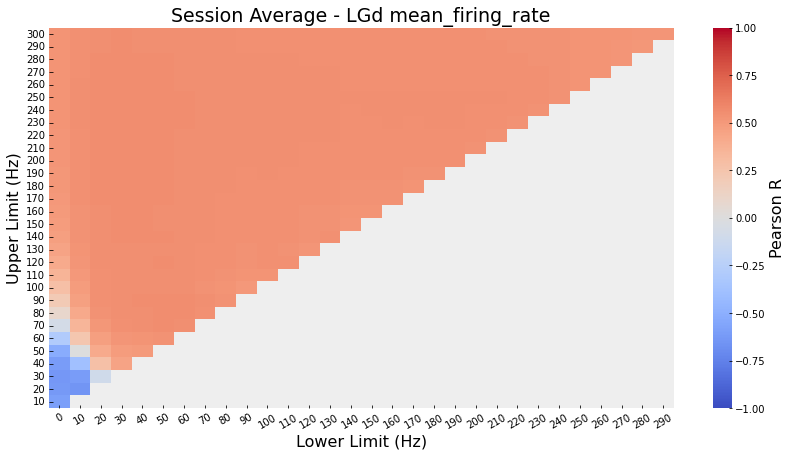

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

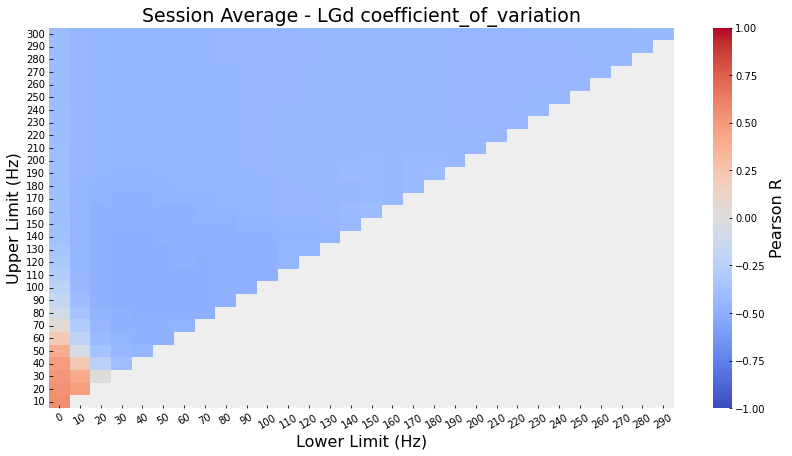

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

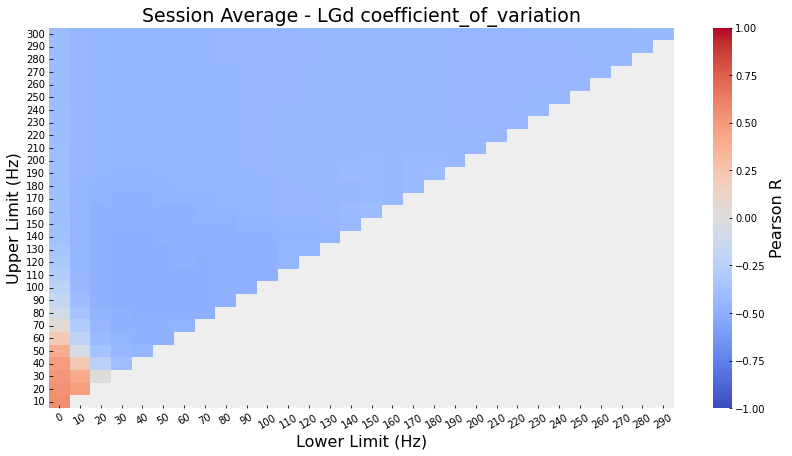

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

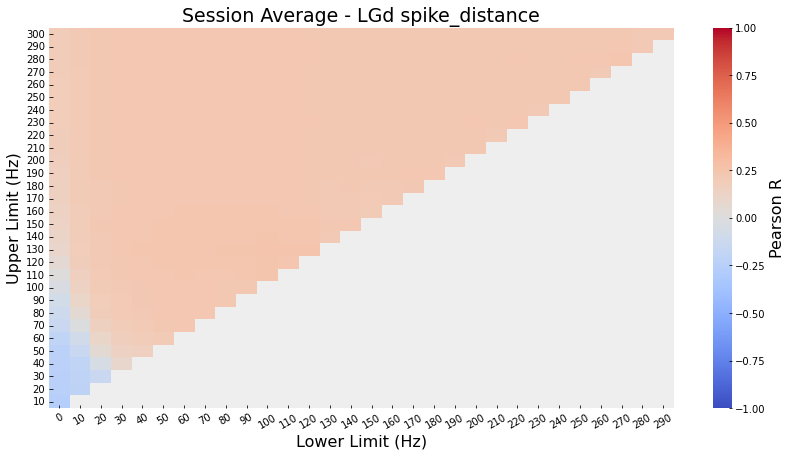

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

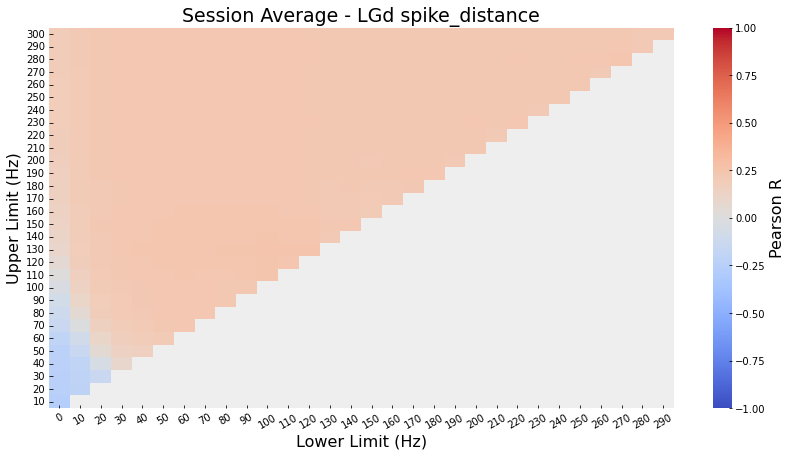

In [21]:
# natural_movie_one_more_repeats
movie_psd = f'{PSD_PATH}/natural_movie'
movie_spikes = f'{SPIKES_IN}/VISp-LGd_natural_movie.csv'
    
metrics = ['mean_firing_rate', 'coefficient_of_variation', 'distance']
regions = ['VISp', 'LGd']

for region in regions:
    for metric in metrics:
        sensitivity_analysis(metric, region, movie_psd, movie_spikes,
                            plot_sessions=True, show_sessions=False,
                            dir_figures=dir_figures + "/non_masked", mask_nonsig=False);
        # save masked
        sensitivity_analysis(metric, region, movie_psd, movie_spikes,
                            plot_sessions=True, show_sessions=False,
                            dir_figures=dir_figures + '/masked', mask_nonsig=True);

# Shuffled Natural Movie

In [22]:
# create directory to save figures
dir_figures = f"{PROJECT_PATH}/figures/sensitivity_analysis/natural_movie_shuffled/behavior_independent"
if not os.path.exists(dir_figures):
    os.makedirs(dir_figures + "/non_masked")
    os.makedirs(dir_figures + "/masked")

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

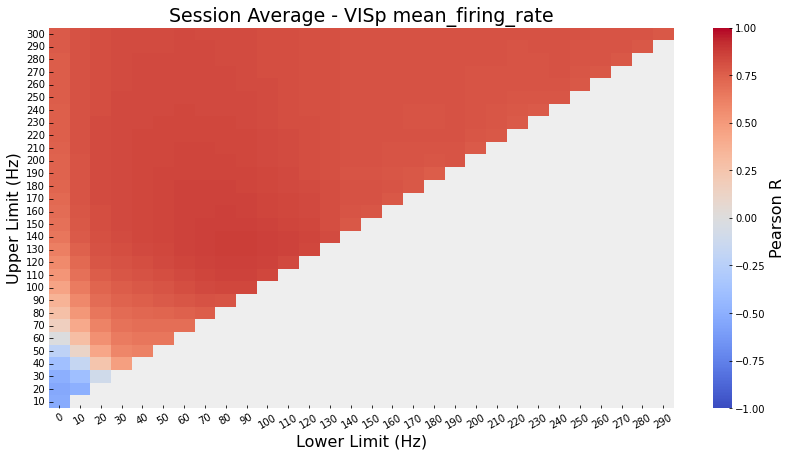

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

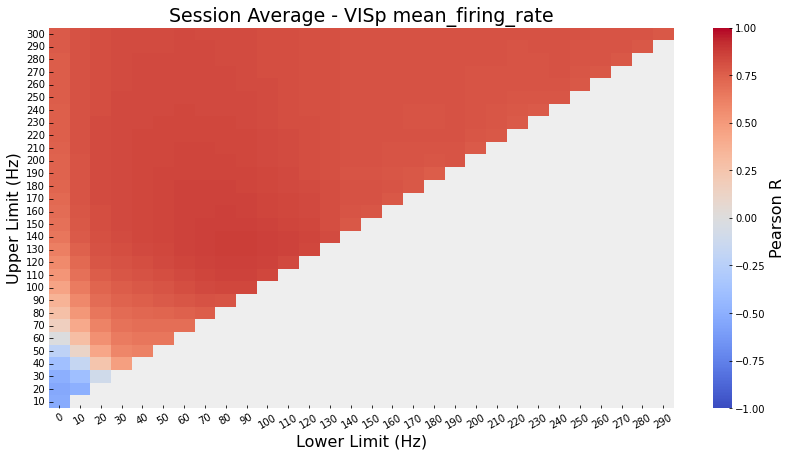

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

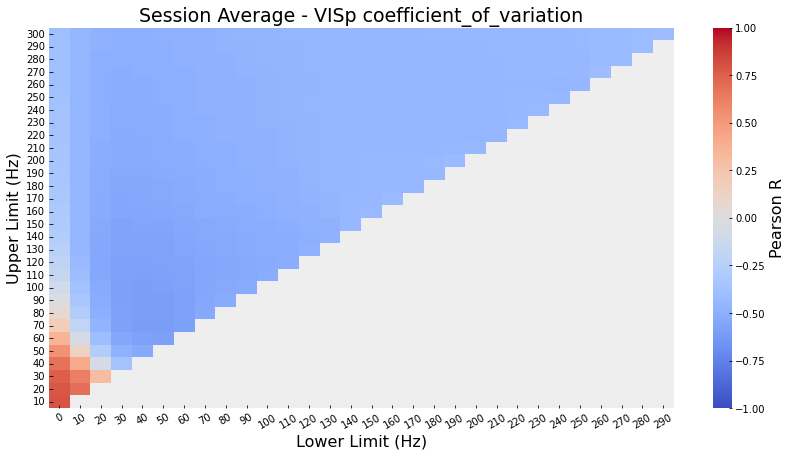

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

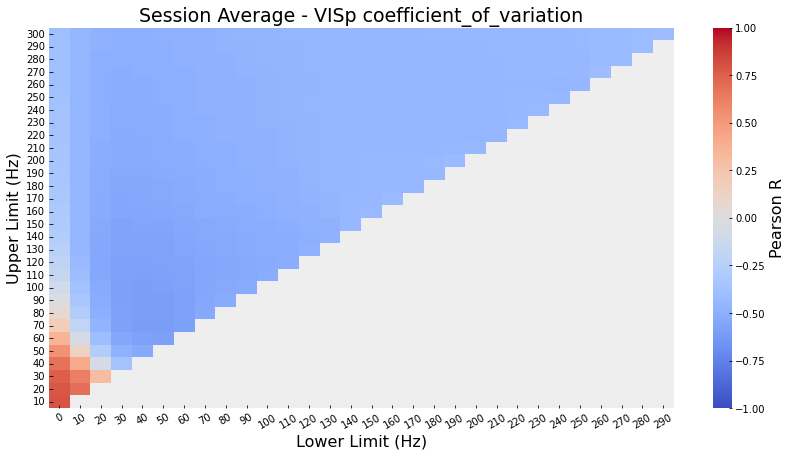

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

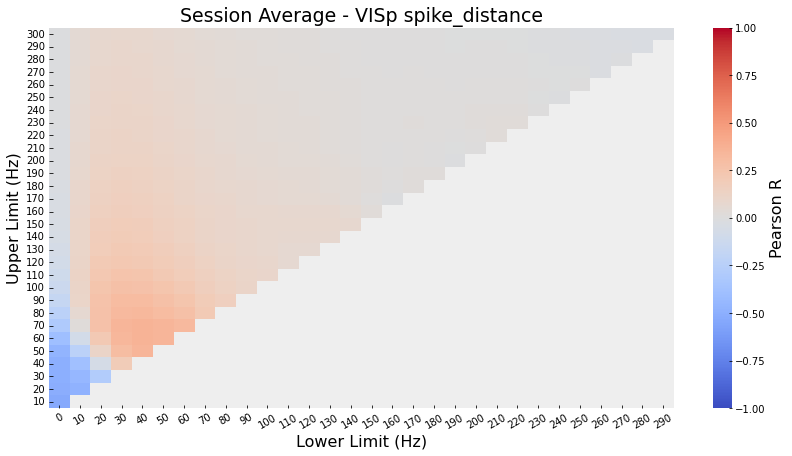

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

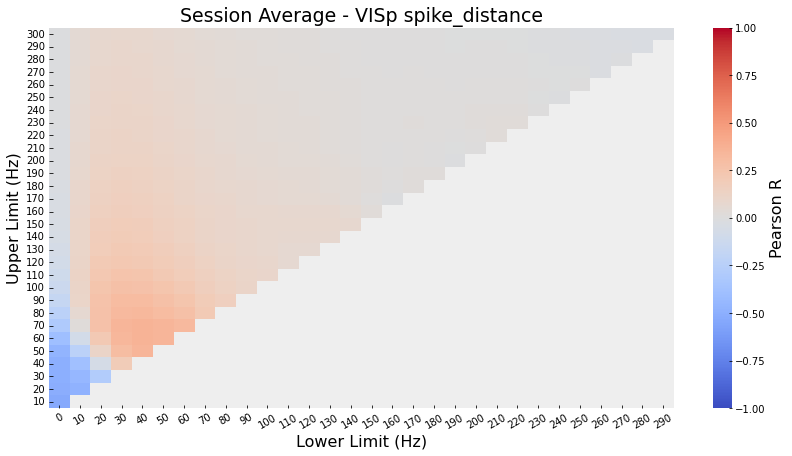

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

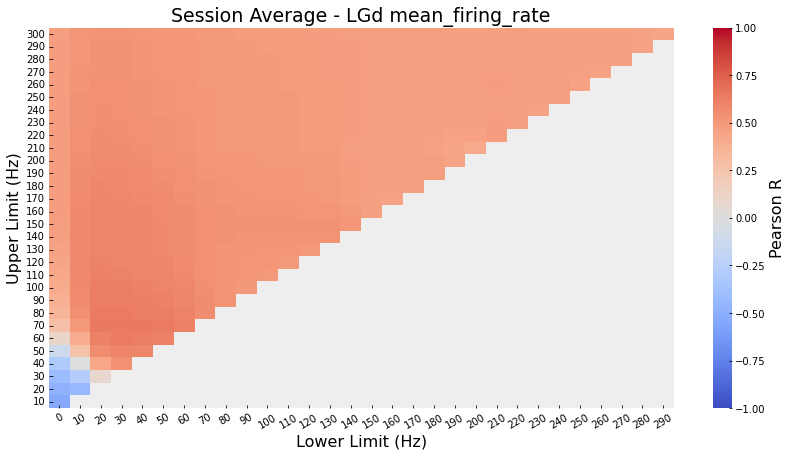

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

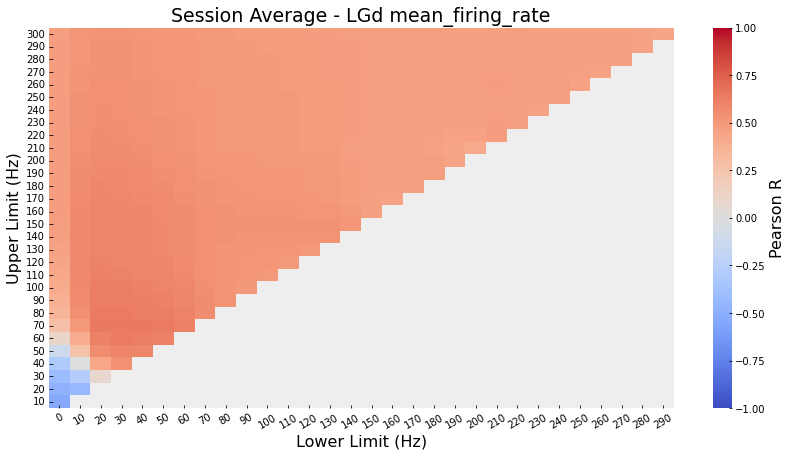

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

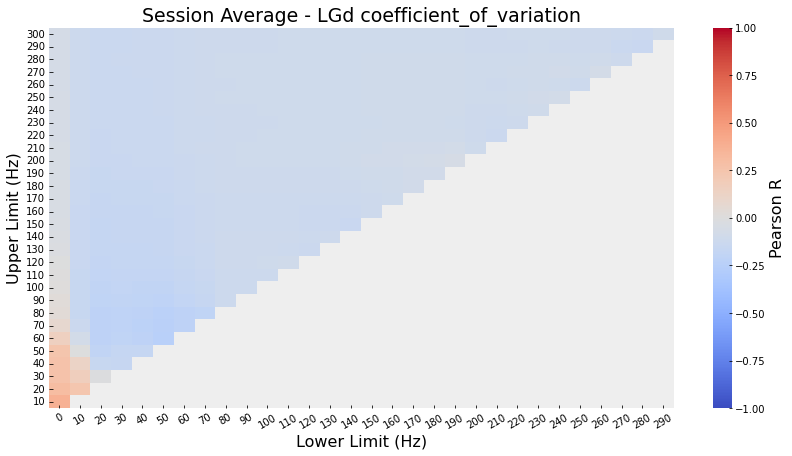

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

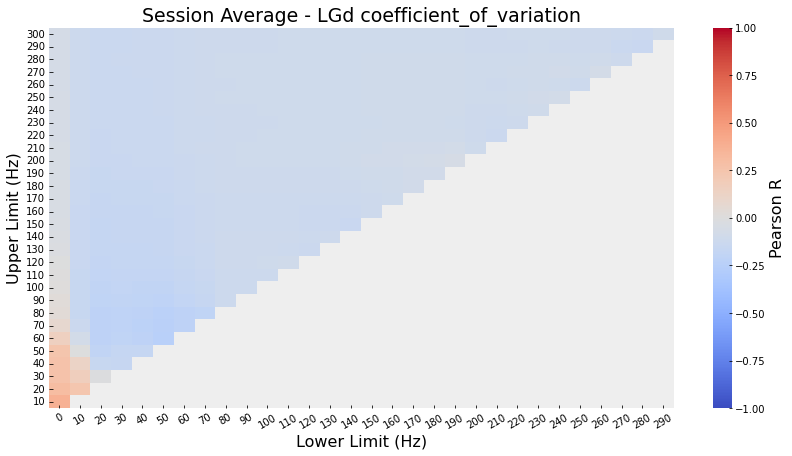

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

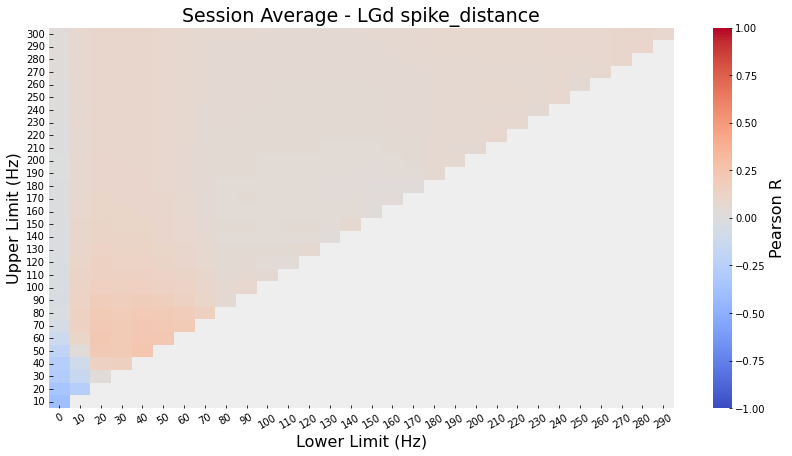

Analyzing File:	847657808_848037572_lfp_psd.npz
Analyzing File:	840012044_868297129_lfp_psd.npz
Analyzing File:	839068429_868929138_lfp_psd.npz
Analyzing File:	835479236_837761710_lfp_psd.npz
Analyzing File:	831882777_832810578_lfp_psd.npz
Analyzing File:	829720705_832129154_lfp_psd.npz
Analyzing File:	821695405_822645897_lfp_psd.npz
Analyzing File:	816200189_836943717_lfp_psd.npz
Analyzing File:	794812542_810758781_lfp_psd.npz
Analyzing File:	789848216_805002031_lfp_psd.npz
Analyzing File:	793224716_805124806_lfp_psd.npz
Analyzing File:	787025148_792586842_lfp_psd.npz
Analyzing File:	786091066_792623921_lfp_psd.npz
Analyzing File:	781842082_792586881_lfp_psd.npz
Analyzing File:	779839471_792645497_lfp_psd.npz
Analyzing File:	778998620_792626847_lfp_psd.npz
Analyzing File:	778240327_792607549_lfp_psd.npz
Analyzing File:	774875821_792602654_lfp_psd.npz
Analyzing File:	771160300_773621942_lfp_psd.npz
Analyzing File:	771990200_773654728_lfp_psd.npz
Analyzing File:	768515987_773549848_lfp_

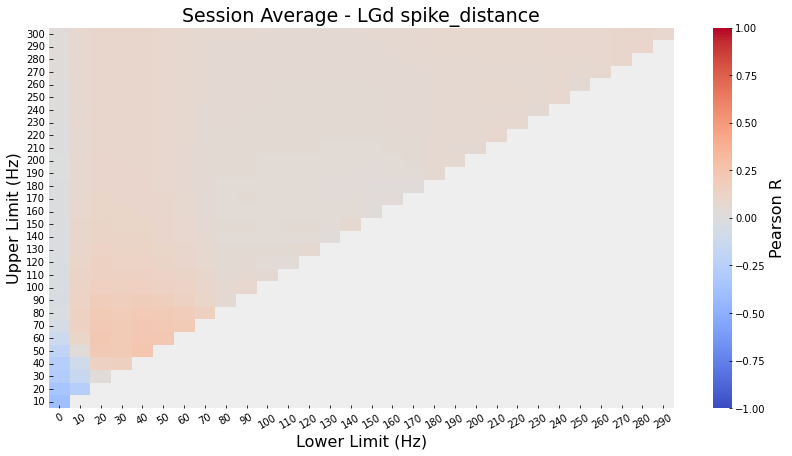

In [23]:
# shuffled
shuffled_psd = f'{PSD_PATH}/natural_movie_shuffled'
shuffled_spikes = f'{SPIKES_IN}/VISp-LGd_natural_movie_shuffled.csv'

for region in regions:
    for metric in metrics:
        sensitivity_analysis(metric, region, shuffled_psd, shuffled_spikes,
                            plot_sessions=True, show_sessions=False,
                            dir_figures=dir_figures + "/non_masked", mask_nonsig=False);
        # save masked
        sensitivity_analysis(metric, region, shuffled_psd, shuffled_spikes,
                            plot_sessions=True, show_sessions=False,
                            dir_figures=dir_figures + "/masked", mask_nonsig=True);

# Absolute Difference Comparison

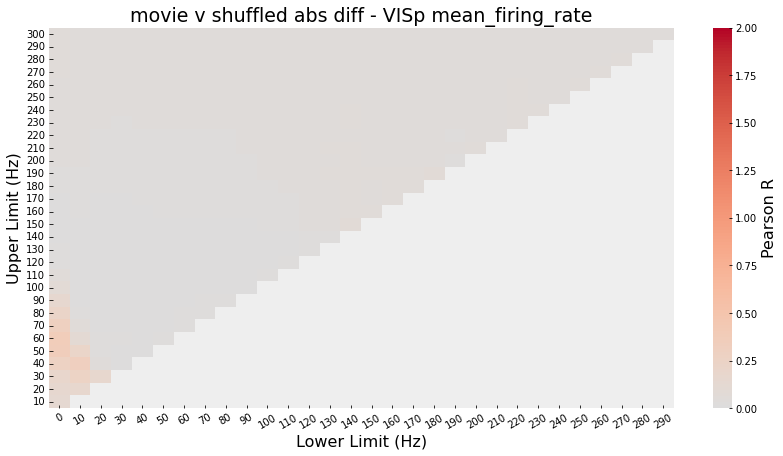

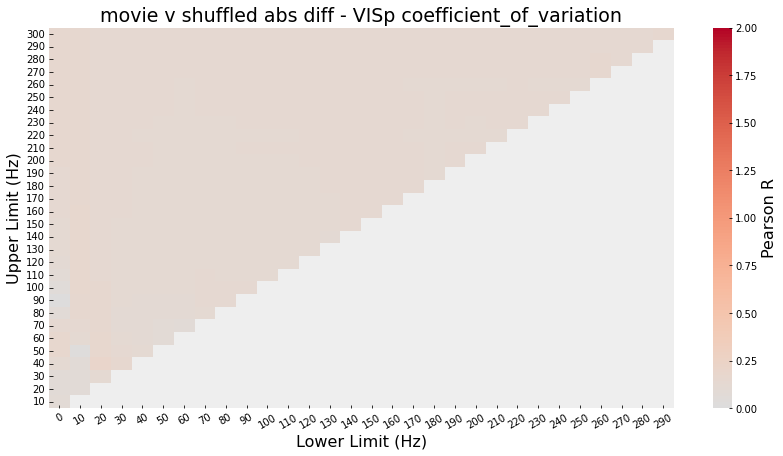

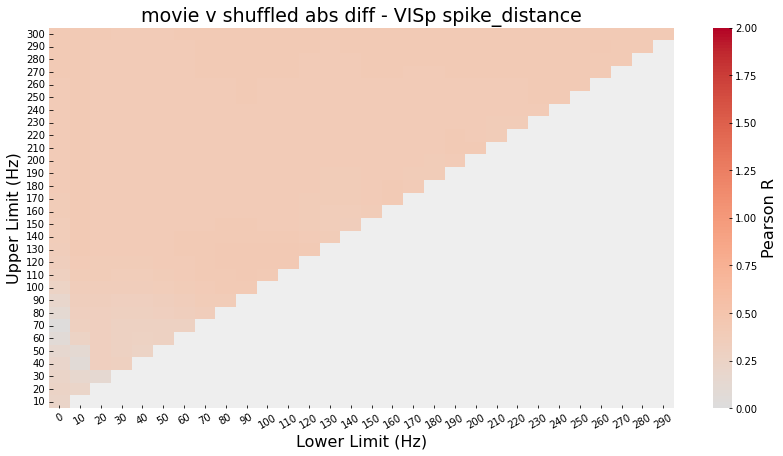

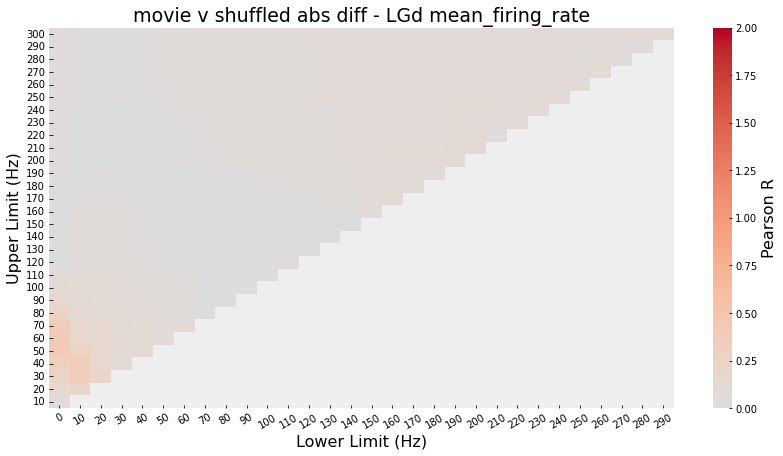

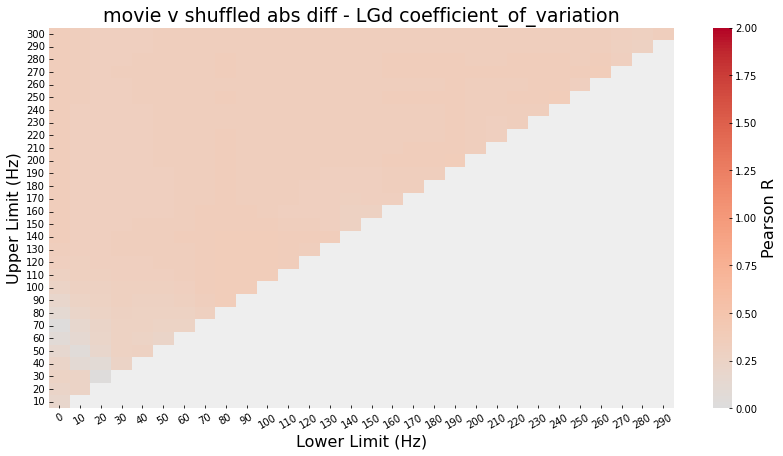

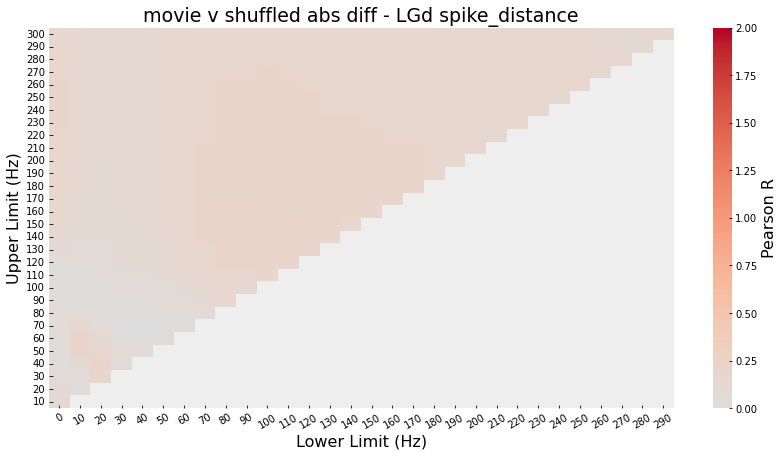

In [27]:
# create directory to save figures
dir_figures = f"{PROJECT_PATH}/figures/sensitivity_analysis/absolute_difference/behavior_independent"
if not os.path.exists(dir_figures):
    os.makedirs(dir_figures)

for region in regions:
    for metric in metrics:
        movie_avg = np.load(f"{MATRICES_OUT}/natural_movie/{region}_{metric}_running=None.npy")
        shuffled_avg = np.load(f"{MATRICES_OUT}/natural_movie_shuffled/{region}_{metric}_running=None.npy")
        
        fname_out=f"{dir_figures}/{region}_{metric}"
        
        # Pearson R diff
        plot_sa_heat_map(np.absolute(np.mean(movie_avg, axis=2)-np.mean(shuffled_avg, axis=2)), xlabels=range(0, 300, 10), \
                         ylabels=range(300, 0, -10), graph_title=f"movie v shuffled abs diff - {region} {metric}", 
                         fname_out=fname_out, show_fig=True, vmin=0, vmax=2);